In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy

%matplotlib inline

In [294]:
def metropolis(mesh, boltz, J, spin):
    """Returns a boolean of the acceptance result of a new state using the Metropolis algorithm and the energy change"""
    # check energy cost of flipping spin
    spin_sum = mesh[spin[0]+1,spin[1]] + mesh[spin[0],spin[1]+1] + mesh[spin[0]-1,spin[1]] + mesh[spin[0],spin[1]-1]
    d_energy = 2*J*mesh[spin[0],spin[1]] * spin_sum
    
    if d_energy > 0:
        accept_prob = boltz[str(abs(spin_sum))]

        sample = random.uniform(0,1)
        
        if sample > accept_prob:
            return False, 0
        
        else:
            return True, d_energy
    
    else:
        return True, d_energy

In [295]:
# input grid init should have 2 extra columns and 2 extra rows for BCs, -1 for down spins, and 1 for up spins
def metropolis_ising(init, boltz, J):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh, ignoring the edges
    spin = [random.choice(range(1,Y-1)),random.choice(range(1,X-1))]
    
    # applying the metropolis algorithm
    accept, d_energy = metropolis(mesh, boltz, J, spin)
    
    if accept == True:
        mesh[spin[0],spin[1]] = -1*mesh[spin[0],spin[1]]

    return [mesh, d_energy]

In [285]:
# input grid init should have 2 extra columns and 2 extra rows for BCs, -1 for down spins, and 1 for up spins
def metropolis_ising_v2(init, boltz, J):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh, ignoring the edges
    spin = [random.choice(range(1,Y-1)),random.choice(range(1,X-1))]
    
    # applying the metropolis algorithm
    spin_sum = mesh[spin[0]+1,spin[1]] + mesh[spin[0],spin[1]+1] + mesh[spin[0]-1,spin[1]] + mesh[spin[0],spin[1]-1]
    d_energy = 2*J*mesh[spin[0],spin[1]] * spin_sum
    
    if d_energy > 0:
        accept_prob = boltz[str(abs(spin_sum))]

        sample = random.uniform(0,1)
        
        if sample <= accept_prob:
            mesh[spin[0],spin[1]] = -1*mesh[spin[0],spin[1]]
            d_mag = 2*mesh[spin[0],spin[1]]
        
        else:
            d_energy = 0
            d_mag = 0
            
    else:
        d_energy = 0
        d_mag = 0

    return [mesh, d_energy, d_mag]

In [195]:
# the input grid uses 2 extra columns and 2 extra rows for BCs
def ising_energy(init, J):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(1, Y-1):
        for j in range(1, X-1):
            energy += -J * init[i,j] * (init[i+1,j] + init[i-1,j] + init[i,j+1] + init[i,j-1])
            
    energy = energy/2
    
    return energy

In [230]:
def ising_mag(init):
    """Computes the magnetization of a lattice in the Ising model"""
    
    mag = np.sum(init)
    
    return mag

In [297]:
def plot_met_ising(init, boltz, J, n, final_only = True):
    """Plots n-step evolution of an Ising model using Metropolis and returns the final grid"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    # set up the extra elements for periodic boundaries (might be faster to roll)
    grid = init[:,:]
    grid = np.insert(grid, 0, np.zeros(Y), axis = 1)
    grid = np.insert(grid, Y + 1, np.zeros(Y), axis = 1)
    grid = np.insert(grid, 0, np.zeros(X+2), axis = 0)
    grid = np.insert(grid, X + 1, np.zeros(X+2), axis = 0)
    
    # implement periodic boundary conditions
    grid[:,0] = grid[:,-2]
    grid[:,-1] = grid[:,1]
    grid[0,:] = grid[-2,:]
    grid[-1,:] = grid[1,:]
    
    # measureables
    energy = ising_energy(grid, J)
    mag = ising_mag(grid)

    for i in range(n):    
        # evolve using metropolis
#        evo, d_energy, d_mag = metropolis_ising(grid, test_boltz, J)
        evo, d_energy = metropolis_ising(grid, test_boltz, J)
        
        # increment energy and magnetization
        energy += d_energy
#        mag += d_mag
        
        # plotting
        if final_only == False:    
            # create discrete colormap, red for up (1) and blue for down (-1)
            cmap = colors.ListedColormap(['blue', 'red'])
            bounds = [1,1,1]
            norm = colors.BoundaryNorm(bounds, cmap.N)

            fig, ax = plt.subplots(figsize=(6,6))
            plt.imshow(evo[1:-1,1:-1], cmap=cmap, norm=norm)
            plt.title(f'2D Ising Model; n = {i+1}', fontsize=20)


            # draw gridlines
            ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
            ax.set_xticks(np.arange(-0.5, X))
            ax.set_yticks(np.arange(-0.5, Y))
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

            display.clear_output(wait = True)

            plt.show()
        
        
        else:
            if i == n-1:    
                # create discrete colormap, red for up (1) and blue for down (-1)
                cmap = colors.ListedColormap(['blue', 'red'])
                bounds = [1,1,1]
                norm = colors.BoundaryNorm(bounds, cmap.N)

                fig, ax = plt.subplots(figsize=(6,6))
                
                # only plot the grid, without the BCs
                plt.imshow(evo[1:-1,1:-1], cmap=cmap, norm=norm)
                plt.title(f'2D Ising Model; n = {n}', fontsize=20)


                # draw gridlines
                ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
                ax.set_xticks(np.arange(-0.5, X))
                ax.set_yticks(np.arange(-0.5, Y))
                ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

                plt.show()
        
        
        # reset iteration variable
        grid = evo[:,:]
        
        # implement periodic BCs
        grid[:,0] = grid[:,-2]
        grid[:,-1] = grid[:,1]
        grid[0,:] = grid[-2,:]
        grid[-1,:] = grid[1,:]
    
    # only want to return the grid without the BCs
    return {'grid' : grid[1:-1, 1:-1], 'energy' : energy, 'bcgrid' : grid}

In [298]:
test = 1*np.ones((30,30))

T = 1000

test_boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}

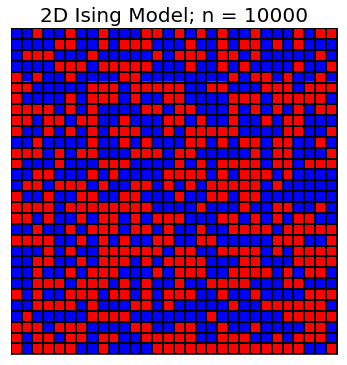

In [304]:
init = test[:,:]

random.seed()
solution = plot_met_ising(init, test_boltz, 1, 10000)

In [273]:
ising_mag(solution['grid'])/900

-0.02666666666666667